# Tomato Leaf Disease Detection

## Importing libraries and reading dataset

In [1]:
import cv2
import os
import numpy as np
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

data_path = '../dataset/tomato/'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))  
print(label_dict)
print(categories)
print(labels)

{'Tomato_Bacterial_spot': 0, 'Tomato_Early_blight': 1, 'Tomato_healthy': 2, 'Tomato_Late_blight': 3, 'Tomato_Leaf_Mold': 4, 'Tomato_Septoria_leaf_spot': 5, 'Tomato__Tomato_mosaic_virus': 6}
['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_healthy', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_mosaic_virus']
[0, 1, 2, 3, 4, 5, 6]


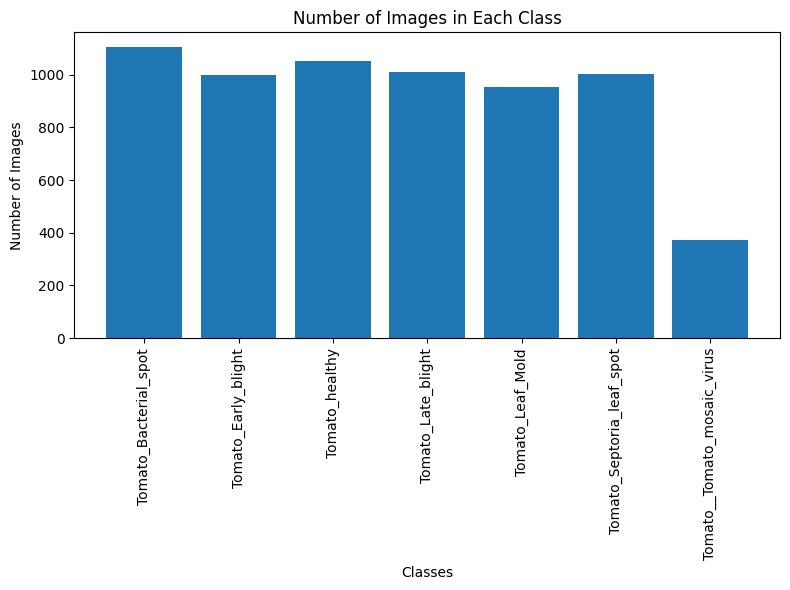

In [2]:
import os
import matplotlib.pyplot as plt

class_counts = {}

for category in categories:
    class_path = os.path.join(data_path, category)
    num_images = len(os.listdir(class_path))
    class_counts[category] = num_images

plt.figure(figsize=(8, 6))  # Increase the figure width
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Number of Images in Each Class')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=90)  # Increase rotation angle for better alignment
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Resizing and converting images into greyscale

In [3]:
from tqdm import tqdm

img_size = 224
data = []
label = []

# Wrap the outer loop with tqdm for progress tracking
for category in tqdm(categories, desc="Processing categories"):
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            # resizing the image into 224x224, as required by ResNet50
            data.append(resized)
            label.append(label_dict[category])
            # appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:', e)
            # if any exception raised, the exception will be printed here. And pass to the next image

Processing categories: 100%|██████████| 7/7 [00:41<00:00,  5.93s/it]


In [4]:
data = np.array(data) / 255.0
data = np.stack((data,) * 3, axis=-1)  # stack grayscale images to create 3 channels
label = np.array(label)
new_label = to_categorical(label)

In [5]:
data.shape

(6490, 224, 224, 3)

## Splitting dataset into testing and training

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, new_label, test_size=0.2, random_state=42)

## Efficient

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB5
from tensorflow.keras.optimizers import Adam

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers in the base EfficientNetB0 model
for layer in base_model.layers:
    layer.trainable = False

# Create the model architecture
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(32, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Define the input and output of the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      1,152 │ block1a_se_excit

 Total params: 34,938,430 (133.28 MB)

 Trainable params: 6,424,903 (24.51 MB)

 Non-trainable params: 28,513,527 (108.77 MB)

In [8]:
# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Assuming you have already defined the other callbacks
history_efficient = model.fit(x_train, y_train, 
                            batch_size=32, 
                            epochs=5, 
                            validation_data=(x_val, y_val))

Epoch 1/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.1630 - loss: 10.5652 - val_accuracy: 0.1704 - val_loss: 1.9349
Epoch 2/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.1614 - loss: 1.9320 - val_accuracy: 0.1704 - val_loss: 1.9255
Epoch 3/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.1694 - loss: 1.9235 - val_accuracy: 0.1704 - val_loss: 1.9195
Epoch 4/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.1622 - loss: 1.9207 - val_accuracy: 0.1704 - val_loss: 1.9161
Epoch 5/5
130/130 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.1667 - loss: 1.9138 - val_accuracy: 0.1704 - val_loss: 1.9136


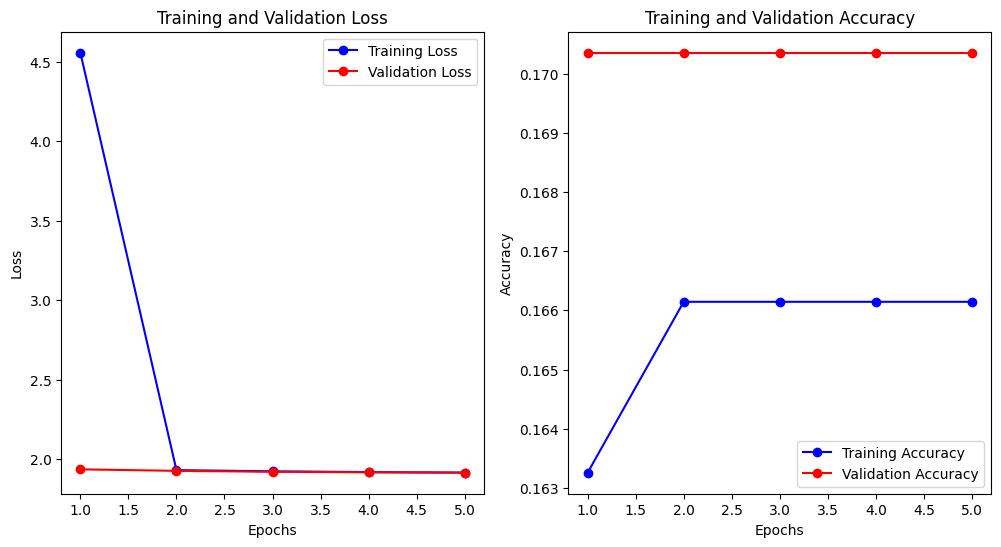

In [10]:
# Learning Curve
train_loss = history_efficient.history['loss']
val_loss = history_efficient.history['val_loss']
train_accuracy = history_efficient.history['accuracy']
val_accuracy = history_efficient.history['val_accuracy'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
model.save('../models/efficient/tomato.h5')

In [12]:
model.save('../models/efficient/tomato.keras')